In [1]:
%matplotlib inline
import os
import glob
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm
from torchvision import transforms
from tensorflow.core.util import event_pb2

from source.models import gn_gan
from source.models import sn_gan_1 as sn_gan

device = torch.device('cuda:1')

In [2]:
# backward compatible
def grad_norm(net_D, *args, **kwargs):
    for x in args:
        x.requires_grad_(True)
    fx = net_D(*args, **kwargs)
    grads = torch.autograd.grad(
        fx, args, torch.ones_like(fx), create_graph=True, retain_graph=True)
    grad_norms = []
    for grad in grads:
        grad_norm = (torch.flatten(grad, start_dim=1) ** 2).sum(1)
        grad_norms.append(grad_norm)
    grad_norm = torch.sqrt(torch.stack(grad_norms, dim=1).sum(dim=1))
    grad_norm = grad_norm.view(
        -1, *[1 for _ in range(len(fx.shape) - 1)])
    fx = (fx / (grad_norm + torch.abs(fx)))
    return fx


class GradNorm(nn.Module):
    def __init__(self, module):
        super(GradNorm, self).__init__()
        self.module = module

    def forward(self, *args, **kwargs):
        return grad_norm(self.module, *args, **kwargs)


def tf_event_iterator(dir_path):
    for path in glob.glob(os.path.join(dir_path, '*')):
        if 'events.out.tfevents' in path:
            try:
                for r in tf.data.TFRecordDataset(path):
                    yield event_pb2.Event.FromString(r.numpy())
            except tf.errors.DataLossError:
                pass


def ema(data, r=0.7):
    ret = []
    for x in data:
        if len(ret) == 0:
            ret.append(x)
        else:
            ret.append(ret[-1] * r + x * (1 - r))
    return np.array(ret)

root = '/mnt/data/backup/iccv21/lipschitz_comparison/'
cache_root = './.cache'
os.makedirs('./figures', exist_ok=True)

## 1. Load Inception Score from tfevent

In [6]:
content = [
    ("SN.CNN3", "SN-GAN-1_CIFAR10_CNN3_WAS"),
#     ("SN.CNN6", "SN-GAN-1_CIFAR10_CNN6_WAS"),
#     ("SN.CNN9", "SN-GAN-1_CIFAR10_CNN9_WAS"),

#     ("GN.CNN3", "GN-GAN_CIFAR10_CNN3_WAS"),
#     ("GN.CNN6", "GN-GAN_CIFAR10_CNN6_WAS"),
#     ("GN.CNN9", "GN-GAN_CIFAR10_CNN9_WAS"),

#     ("GP.CNN3", "GP-GAN_CIFAR10_CNN3_WAS"),
#     ("GP.CNN6", "GP-GAN_CIFAR10_CNN6_WAS"),
#     ("GP.CNN9", "GP-GAN_CIFAR10_CNN9_WAS"),
    
#     ("CR.CNN3", "CR-GAN_CIFAR10_CNN3_WAS"),
#     ("CR.CNN6", "CR-GAN_CIFAR10_CNN6_WAS"),
#     ("CR.CNN9", "CR-GAN_CIFAR10_CNN9_WAS"),
]

with tqdm(content) as pbar:
    for cache_name, dir_name in pbar:
        pbar.set_description(cache_name)
        cache_path = os.path.join(cache_root, f'{cache_name}.tbeval.pt')
        if os.path.isfile(cache_path):
            pbar.write(f'Using cache {cache_path}')
        else:
            evaluation = {
                'FID': [],
                'FID_EMA': [],
                'IS': [],
                'IS_EMA': [],
                'IS_std': [],
                'IS_std_EMA': [],
                'step': [],
            }
            keys = set(evaluation.keys())
            dir_path = os.path.join(root, dir_name)
            for event in tf_event_iterator(dir_path):
                for value in event.summary.value:
                    if value.tag in keys:
                        evaluation[value.tag].append(value.simple_value)
                        if value.tag == 'FID_EMA':
                            evaluation['step'].append(event.step)
            torch.save(evaluation, cache_path)

In [7]:
for k, v in evaluation.items():
    print(k, len(v))

FID 0
FID_EMA 0
IS 21
IS_EMA 0
IS_std 21
IS_std_EMA 0
step 0


## Plot Inception Scores virsus training iterations

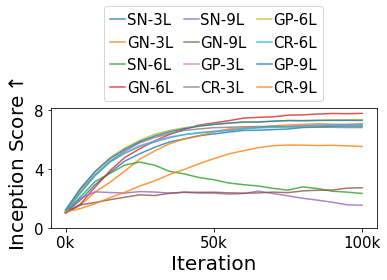

In [5]:
ticks_fontsize = 15
label_fontsize = 20
legend_fontsize = 15

plt.figure(figsize=(5.5, 4))
for legend_name, (x, y) in inception_scores.items():
    plt.plot(x, ema(y), label=legend_name, linewidth=1.5, alpha=0.8)

xticks = [0, 50000, 100000]
xticks_label = ['%dk' % (x / 1000) for x in xticks]
plt.xticks(xticks, xticks_label, fontsize=ticks_fontsize)
plt.xlabel('Iteration', fontsize=label_fontsize)
# ax.tick_params(axis='x', labelsize=label_fontsize)

yticks = [0, 4, 8]
plt.yticks(yticks, fontsize=ticks_fontsize)
plt.ylabel('Inception Score' + r'$\uparrow$', fontsize=label_fontsize, y=0.54)

plt.legend(
    loc='lower center', fontsize=legend_fontsize,
    ncol=3, columnspacing=0.7, handlelength=1.0, handletextpad=0.1,
    bbox_to_anchor=(0.5, 1))
plt.tight_layout()
# plt.savefig('./figures/vis_IS_vs_CNN.png')

## Load Model and Calculate Lipschitz Constant for each Layer

In [51]:
def auto_spectral_norm(module, in_dim, iteration=100):
    v = normalize(torch.randn(size=in_dim)).to(device)
    with torch.no_grad():
        output_shape = module(v).shape
    v_dummy = torch.randn(size=in_dim, requires_grad=True).to(device)

    if isinstance(module, sn_gan.SpectralNorm):
        bias = getattr(module.module, 'bias')
    else:
        bias = getattr(module, 'bias')
    while len(bias.shape) < len(output_shape) - 1:
        bias = bias.unsqueeze(-1)

    for _ in trange(iteration, leave=False):
        with torch.no_grad():
            if bias is not None:
                u = normalize(module(v) - bias)
            else:
                u = normalize(module(v))
        v = torch.autograd.grad(module(v_dummy), v_dummy, u)[0]
        with torch.no_grad():
            v = normalize(v)

    with torch.no_grad():
        if bias is not None:
            return torch.dot(u.reshape(-1), (module(v) - bias).reshape(-1))
        else:
            return torch.dot(u.reshape(-1), module(v).reshape(-1))


class ForwardHook:
    def __init__(self):
        self.in_shapes = []
    
    def __call__(self, module, inputs, outputs):
        self.in_shapes.append(list(inputs[0].shape))

content = [
    ("SN.CNN3", "SN-GAN-1_CIFAR10_CNN3_WAS", sn_gan.Discriminator3()),
    ("SN.CNN6", "SN-GAN-1_CIFAR10_CNN6_WAS", sn_gan.Discriminator6()),
    ("SN.CNN9", "SN-GAN-1_CIFAR10_CNN9_WAS", sn_gan.Discriminator9()),
    
    ("GN.CNN3", "GN-GAN_CIFAR10_CNN3_WAS", GradNorm(gn_gan.Discriminator3())),
    ("GN.CNN6", "GN-GAN_CIFAR10_CNN6_WAS", GradNorm(gn_gan.Discriminator6())),
    ("GN.CNN9", "GN-GAN_CIFAR10_CNN9_WAS", GradNorm(gn_gan.Discriminator9())),
    
    ("GP.CNN3", "GP-GAN_CIFAR10_CNN3_WAS", gn_gan.Discriminator3()),
    ("GP.CNN6", "GP-GAN_CIFAR10_CNN6_WAS", gn_gan.Discriminator6()),
    ("GP.CNN9", "GP-GAN_CIFAR10_CNN9_WAS", gn_gan.Discriminator9()),
    
    ("CR.CNN3", "CR-GAN_CIFAR10_CNN3_WAS", gn_gan.Discriminator3()),
    ("CR.CNN6", "CR-GAN_CIFAR10_CNN6_WAS", gn_gan.Discriminator6()),
    ("CR.CNN9", "CR-GAN_CIFAR10_CNN9_WAS", gn_gan.Discriminator9()),
]
spectralnorms = defaultdict(list)

with tqdm(content) as pbar:
    for cache_name, dir_name, net_D in pbar:
        pbar.set_description(cache_name)
        cache_path = os.path.join(cache_root, f'{cache_name}.LayerSN.pt')
        if os.path.isfile(cache_path):
            pbar.write(f'Using cache {cache_path}')
        else:
            spectralnorms = []
            
            net_D = net_D.to(device)
            net_D.eval()
            handles = []
            modules = []
            hook = ForwardHook()
            for m in net_D.modules():
                if cache_name.startswith('SN'):
                    if isinstance(m, sn_gan.SpectralNorm) and isinstance(m.module, nn.Conv2d):
                        record = True
                    else:
                        record = False
                else:
                    record = isinstance(m, nn.Conv2d)
                if record:
                    handles.append(m.register_forward_hook(hook))
                    modules.append(m)
            
            # initialize shape of u and v for SpectralNorm
            net_D(torch.rand((1, 3, 32, 32)).to(device))
            for handle in handles:
                handle.remove()

            # load model
            ckpt = torch.load(os.path.join(root, dir_name, 'model.pt'))
            net_D.load_state_dict(ckpt['net_D'])
            for m, in_shape in tqdm(list(zip(modules, hook.in_shapes)), leave=False):
                spectralnorms.append(auto_spectral_norm(m, in_shape).item())
            
            torch.save(spectralnorms, cache_path)

Using cache ./.cache/SN.CNN3.LayerSN.pt
Using cache ./.cache/SN.CNN6.LayerSN.pt
Using cache ./.cache/SN.CNN9.LayerSN.pt
Using cache ./.cache/GN.CNN3.LayerSN.pt
Using cache ./.cache/GN.CNN6.LayerSN.pt
Using cache ./.cache/GN.CNN9.LayerSN.pt
Using cache ./.cache/GP.CNN3.LayerSN.pt
Using cache ./.cache/GP.CNN6.LayerSN.pt
Using cache ./.cache/GP.CNN9.LayerSN.pt


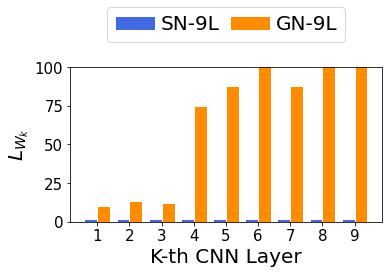

In [60]:
legend_fontsize = 20
ticks_fontsize = 15
label_fontsize = 20
barWidth = 0.4

content = {
    'SN-9L': {
        'cache_name': 'SN.CNN9',
        'color': 'royalblue'
    },
    'GN-9L': {
        'cache_name': 'GN.CNN9',
        'color': 'darkorange'
    },
}

plt.figure(figsize=(5.5, 4))
for i, (legend_name, cfg) in enumerate(content.items()):
    cache_path = os.path.join(cache_root, f'{cfg["cache_name"]}.LayerSN.pt')
    spectralnorms = torch.load(cache_path)
    if legend_name.startswith('SN'):
        spectralnorms = torch.tensor(spectralnorms) * 2
    r = np.arange(len(spectralnorms)) + i * barWidth
    plt.bar(r, spectralnorms, width=barWidth, color=cfg['color'], edgecolor='white', label=legend_name)

# x-axis
tick_center = np.arange(len(spectralnorms)) + (len(content) - 1) * 0.5 * barWidth
xtick_labels = np.arange(len(spectralnorms)) + 1
plt.xticks(tick_center, xtick_labels, fontsize=ticks_fontsize)
plt.xlabel('K-th CNN Layer', fontsize=label_fontsize)

# y-axis
yticks = np.arange(0, 101, 25)
plt.ylim(0, 100)
plt.yticks(yticks, yticks, fontsize=ticks_fontsize)
plt.ylabel(r'$L_{W_k}$', fontsize=label_fontsize)

plt.legend(
    loc='lower center', fontsize=legend_fontsize,
    ncol=3, columnspacing=0.5, handlelength=2.0, handletextpad=0.3,
    bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.savefig('./figures/vis_lipschitz_vs_layer.png')

## Estimate Lipschitz constants

In [69]:
def calc_grad_norm(net_D, x):
    x.requires_grad_(True)
    y = net_D(x).mean()
    grad = torch.autograd.grad(y, x)[0]
    gn = torch.sqrt((torch.flatten(grad, start_dim=1) ** 2).sum(dim=1))
    gn = gn * x.shape[0]
    return gn

def estimate_max_grad(net_D, net_G, loader, n=50000, batch_size=64, z_dim=128):
    net_G.eval()
    net_D.eval()
    for p in net_D.parameters():
        p.requires_grad_(False)
    
    max_fake_gn = 0
    max_real_gn = 0
    max_midd_gn = 0
    max_rand_gn = 0
    for real, _ in tqdm(loader, desc="sampling", leave=False):        
        # P_g
        with torch.no_grad():
            z = torch.randn((real.size(0), z_dim)).to(device)
            fake = net_G(z)
        max_fake_gn = max(
            max_fake_gn,
            calc_grad_norm(net_D, fake).max().cpu().item())

        # P_r
        real = real.to(device)
        max_real_gn = max(
            max_real_gn,
            calc_grad_norm(net_D, real).max().cpu().item())

        # \hat{x}
        with torch.no_grad():
            t = torch.rand((real.size(0), 1, 1, 1)).to(device)
            midd = fake * t + real * (1 - t)
        max_midd_gn = max(
            max_midd_gn,
            calc_grad_norm(net_D, midd).max().cpu().item())
        
        # P_g + normal(0, 0.1)
        rand = torch.clamp(real + torch.randn_like(real) * 0.1, min=-1, max=1)
        max_rand_gn = max(
            max_rand_gn,
            calc_grad_norm(net_D, rand).max().cpu().item())
        
    
    return {
        'fake': max_fake_gn,
        'real': max_real_gn,
        'midd': max_midd_gn,
        'rand': max_rand_gn,
    }


z_dim = 128
batch_size = 64
content = [
    ("SN.CNN3", "SN-GAN-1_CIFAR10_CNN3_WAS", sn_gan.Discriminator3(), sn_gan.Generator(z_dim)),
    ("SN.CNN6", "SN-GAN-1_CIFAR10_CNN6_WAS", sn_gan.Discriminator6(), sn_gan.Generator(z_dim)),
    ("SN.CNN9", "SN-GAN-1_CIFAR10_CNN9_WAS", sn_gan.Discriminator9(), sn_gan.Generator(z_dim)),

    ("GN.CNN3", "GN-GAN_CIFAR10_CNN3_WAS", GradNorm(gn_gan.Discriminator3()), gn_gan.Generator(z_dim)),
    ("GN.CNN6", "GN-GAN_CIFAR10_CNN6_WAS", GradNorm(Discriminator6()), gn_gan.Generator(z_dim)),
    ("GN.CNN9", "GN-GAN_CIFAR10_CNN9_WAS", GradNorm(Discriminator9()), gn_gan.Generator(z_dim)),

    ("GP.CNN3", "GP-GAN_CIFAR10_CNN3_WAS", gn_gan.Discriminator3(), gn_gan.Generator(z_dim)),
    ("GP.CNN6", "GP-GAN_CIFAR10_CNN6_WAS", gn_gan.Discriminator6(), gn_gan.Generator(z_dim)),
    ("GP.CNN9", "GP-GAN_CIFAR10_CNN9_WAS", gn_gan.Discriminator9(), gn_gan.Generator(z_dim)),
    
    ("CR.CNN3", "CR-GAN_CIFAR10_CNN3_WAS", gn_gan.Discriminator3(), gn_gan.Generator(z_dim)),
    ("CR.CNN6", "CR-GAN_CIFAR10_CNN6_WAS", gn_gan.Discriminator6(), gn_gan.Generator(z_dim)),
    ("CR.CNN9", "CR-GAN_CIFAR10_CNN9_WAS", gn_gan.Discriminator9(), gn_gan.Generator(z_dim)),
]

dataset = torchvision.datasets.CIFAR10(
    './data', train=True, download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))
dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True,
        num_workers=4, drop_last=True)

with tqdm(content) as pbar:
    for cache_name, dir_name, net_D, net_G in pbar:
        cache_path = os.path.join(cache_root, f'{cache_name}.SN.pt')
        if os.path.isfile(cache_path):
            pbar.write(f'Using cache {cache_path}')
        else:
            gn_values = {}
            net_D = net_D.to(device)
            net_G = net_G.to(device)
            net_D(torch.rand((1, 3, 32, 32)).to(device))
            for step in tqdm([1] + list(range(5000, 100001, 5000))):
                if os.path.isfile(os.path.join(root, dir_name, f'{step}.pt')):
                    ckpt = torch.load(os.path.join(root, dir_name, f'{step}.pt'))
                else:
                    ckpt = torch.load(os.path.join(root, dir_name, f'{step:06d}.pt'))
                net_G.load_state_dict(ckpt['net_G'])
                net_D.load_state_dict(ckpt['net_D'])
                gn_dict = estimate_max_grad(net_D, net_G, dataloader, len(dataset), batch_size=batch_size, z_dim=z_dim)
                for gn_name, gn_value in gn_dict.items():
                    if gn_name in gn_values:
                        gn_values[gn_name].append(gn_value)
                    else:
                        gn_values[gn_name] = [gn_value]
            torch.save(gn_values, cache_path)

Files already downloaded and verified


Using cache ./.cache/SN.CNN3.SN.pt
Using cache ./.cache/SN.CNN6.SN.pt
Using cache ./.cache/SN.CNN9.SN.pt
Using cache ./.cache/GN.CNN3.SN.pt
Using cache ./.cache/GN.CNN6.SN.pt
Using cache ./.cache/GN.CNN9.SN.pt
Using cache ./.cache/GP.CNN3.SN.pt
Using cache ./.cache/GP.CNN6.SN.pt
Using cache ./.cache/GP.CNN9.SN.pt
Using cache ./.cache/CR.CNN3.SN.pt
Using cache ./.cache/CR.CNN6.SN.pt
Using cache ./.cache/CR.CNN9.SN.pt



## Plot Lipschitz constant curve

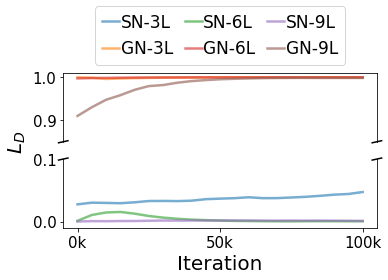

In [70]:
legend_fontsize = 17
ticks_fontsize = 15
label_fontsize = 20

more_values = defaultdict(list)
content = {
    'SN-3L': 'SN.CNN3',
    'GN-3L': 'GN.CNN3',
    'SN-6L': 'SN.CNN6',
    'GN-6L': 'GN.CNN6',
    'SN-9L': 'SN.CNN9',
    'GN-9L': 'GN.CNN9',
}
for legend_name, cache_name in content.items():
    cache_path = os.path.join(cache_root, f'{cache_name}.SN.pt')
    gns = torch.load(cache_path)
    x = [1] + list(range(5000, 100001, 5000))
    y = []
    for fake_gn, real_gn in zip(gns['fake'], gns['real']):
        max_gn = max([fake_gn, real_gn])
        y.append(max_gn)
    more_values[legend_name] = (x, y)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5.5, 4))
fig.subplots_adjust(hspace=5)
ax1.set_ylim(0.85, 1.01)
ax2.set_ylim(-0.01, 0.1)

# setup ticks
ax1.tick_params(bottom=False)
ax2.tick_params(bottom=True)

# turn off spines
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

d = 0.015  # line length 
ax1.plot((-d, +d), (-d, +d), c='k', clip_on=False, transform=ax1.transAxes)
ax1.plot((1 - d, 1 + d), (-d, +d), c='k', clip_on=False, transform=ax1.transAxes)
ax2.plot((-d, +d), (1 - d, (1 + d)), c='k', clip_on=False, transform=ax2.transAxes)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), c='k', clip_on=False, transform=ax2.transAxes)

for legend_name, (x, y) in more_values.items():
    ax1.plot(x, ema(y), label=legend_name, linewidth=2.5, alpha=0.6)
    ax2.plot(x, ema(y), label=legend_name, linewidth=2.5, alpha=0.6)

# lower figure
xticks = [0, 50000, 100000]
yticks = [0, 0.1]
xticks_label = ['%dk' % (x / 1000) for x in xticks]
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks_label)
ax2.tick_params(axis='x', labelsize=ticks_fontsize)
ax2.set_xlabel('Iteration', fontsize=label_fontsize)
ax2.set_yticks(yticks)
ax2.tick_params(axis='y', labelsize=ticks_fontsize)

# lower upper
yticks = [0.9, 1.0]
ax1.set_yticks(yticks)
ax1.tick_params(axis='y', labelsize=ticks_fontsize)
ax1.set_ylabel(r'$L_D$', fontsize=label_fontsize, y=0)

ax1.legend(
    loc='lower center', fontsize=legend_fontsize,
    ncol=3, columnspacing=0.7, handlelength=1.0, handletextpad=0.1,
    bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.savefig('./figures/vis_lipschitz_vs_depth.png')

## Plot Lipschitz constant curve of training for rebuttal

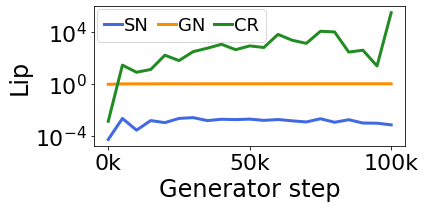

In [6]:
ticks_fontsize = 22
label_fontsize = 24
legend_fontsize = 18

content = {
    'SN': {
        'cache_name': 'SN.CNN9',
        'color': 'royalblue',
    },
    'GN': {
        'cache_name': 'GN.CNN9',
        'color': 'darkorange',
    },
    'CR': {
        'cache_name': 'CR.CNN9',
        'color': 'forestgreen',
    }
}
include = ['fake', 'real']

plt.figure(figsize=(6, 3))
for legend_name, cfg in content.items():
    cache_path = os.path.join(cache_root, f'{cfg["cache_name"]}.SN.pt')
    gns = torch.load(cache_path)
    y_max = []
    y_min = []
    for gn in zip(*[gns[key] for key in include]):
        y_max.append(max(gn))
        y_min.append(min(gn))
    x = [1] + list(range(5000, 100001, 5000))
    plt.plot(x, y_max, label=legend_name, color=cfg['color'], linewidth=3.0)

xticks = [0, 50000, 100000]
xticks_label = ['%dk' % (x / 1000) for x in xticks]
plt.xticks(xticks, xticks_label, fontsize=ticks_fontsize)
plt.xlabel('Generator step', fontsize=label_fontsize)

plt.yscale("log")
yticks = [1e-4, 1, 1e4]
plt.yticks(yticks, fontsize=ticks_fontsize)
plt.ylabel('Lip', fontsize=label_fontsize)

plt.legend(
    loc='upper left', fontsize=legend_fontsize,
    ncol=3, columnspacing=0.5, handlelength=1.0, handletextpad=0.1,
    bbox_to_anchor=(-0.02, 1.045))
# plt.legend(
#     loc='upper left', fontsize=legend_fontsize,
#     ncol=3, columnspacing=0.5, handlelength=1.0, handletextpad=0.1)
plt.tight_layout()
plt.savefig('./figures/vis_lipschitz_of_gn_and_cr.png')

In [8]:
content = [
    ("SN.CELEBHQ128", "SN-GAN_CELEBHQ128_RES_0_BS64"),
    ("GN.CELEBHQ128", "GN-GAN_CELEBHQ128_RES_0_BS64"),
    ("SN.CELEBHQ256", "SN-GAN_CELEBHQ256_RES_0_BS64"),
    ("GN.CELEBHQ256", "GN-GAN_CELEBHQ256_RES_0_BS32x2"),
]

root = './logs/'
with tqdm(content) as pbar:
    for cache_name, dir_name in pbar:
        pbar.set_description(cache_name)
        cache_path = os.path.join(cache_root, f'{cache_name}.tbeval.pt')
        if os.path.isfile(cache_path):
            pbar.write(f'Using cache {cache_path}')
        else:
            evaluation = {
                'FID': [],
                'FID_EMA': [],
                'IS': [],
                'IS_EMA': [],
                'IS_std': [],
                'IS_std_EMA': [],
                'step': [],
            }
            keys = set(evaluation.keys())
            dir_path = os.path.join(root, dir_name)
            for event in tf_event_iterator(dir_path):
                for value in event.summary.value:
                    if value.tag in keys:
                        evaluation[value.tag].append(value.simple_value)
                        if value.tag == 'FID_EMA':
                            evaluation['step'].append(event.step)
            torch.save(evaluation, cache_path)

Using cache ./.cache/SN.CELEBHQ128.tbeval.pt
Using cache ./.cache/GN.CELEBHQ128.tbeval.pt
Using cache ./.cache/GN.CELEBHQ256.tbeval.pt



In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

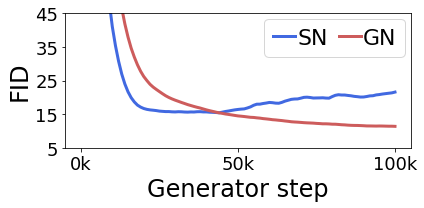

In [13]:
ticks_fontsize = 18
label_fontsize = 24
legend_fontsize = 22

content = {
    'SN': {
        'cache_name': "SN.CELEBHQ256",
        'color': 'royalblue',
    },
    'GN': {
        'cache_name': "GN.CELEBHQ256",
        'color': 'indianred',
    },
}
target = 'FID_EMA'

plt.figure(figsize=(6, 3))
for legend_name, cfg in content.items():
    cache_path = os.path.join(cache_root, f'{cfg["cache_name"]}.tbeval.pt')
    evaluation = torch.load(cache_path)
    step, fid = evaluation['step'], ema(evaluation[target])
    if legend_name == 'SN':
        plt.plot(step, fid, label=legend_name, color=cfg['color'], linewidth=3.0)
    else:
        plt.plot(step, fid + 5, label=legend_name, color=cfg['color'], linewidth=3.0)

xticks = [0, 50000, 100000]
xticks_label = ['%dk' % (x / 1000) for x in xticks]
plt.xticks(xticks, xticks_label, fontsize=ticks_fontsize)
plt.xlabel('Generator step', fontsize=label_fontsize)
# ax.tick_params(axis='x', labelsize=label_fontsize)

yticks = [5, 15, 25, 35, 45]
plt.ylim(10, 45)
plt.yticks(yticks)
plt.yticks(fontsize=ticks_fontsize)
plt.ylabel('FID', fontsize=label_fontsize)

plt.legend(
    loc='upper right', fontsize=legend_fontsize,
    ncol=2, columnspacing=0.5, handlelength=1.0, handletextpad=0.1,
    bbox_to_anchor=(1.015, 1.04))
plt.tight_layout()
plt.savefig('./figures/vis_fid_of_celebhq.png')
plt.show()